In [1]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
from torch import nn, optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
import seaborn as sns

# Req for package
import sys
sys.path.append("../")
from SkinLearning.NN.Helpers import train, test, DEVICE, getParameterLoss, setSeed
from SkinLearning.NN.Models import MultiLSTM
from SkinLearning.Utils.Dataset import getDataset, getSplit
from SkinLearning.Utils.Plotting import plotParameterBars


torch.backends.cudnn.benchmark = True

In [5]:
setSeed()

In [6]:
# Remove one FC LAyer
class MultiGRU(nn.Module):
    def __init__(self, hidden_size=256, single_fc=True, out="f_hidden"):
        super(MultiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.out = out
        
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.gru = nn.GRU(15, hidden_size, batch_first=True)
        
        input_tensor = torch.zeros(32, 512, 15)
        output, hidden = self.gru(input_tensor)
        

        fc_in = hidden_size
        if out == 'output':
            fc_in = output.shape[1] * output.shape[2]
        elif out == 'f-output':
            fc_in = output.shape[2]
        elif out == 'hidden':
            out = hidden_size * output.shape[2]
        elif out == 'f-hiden':
            fc_in = output.shape[2]
        elif out == 'h+o':
            fc_in = output.shape[1]
            
        if single_fc:
            self.fc = nn.Linear(fc_in, 6)
        else:
            self.fc = nn.Sequential(
                nn.Linear(fc_in, 128),
                nn.ReLU(),
                nn.Linear(128 , 64),
                nn.ReLU(),
                nn.Linear(64, 6),   
            )
        
        if single_fc:
            self.fc = nn.Linear(fc_in, 6)
        else:
            self.fc = nn.Sequential(
                nn.Linear(fc_in, 128),
                nn.ReLU(),
                nn.Linear(128 , 64),
                nn.ReLU(),
                nn.Linear(64, 6),   
            )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        #h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        o, h = self.gru(x)
        
        if self.out == "f_hidden":
            x = h[-1].reshape(batch_size, -1)
        elif self.out == "hidden":
            x = h.reshape(batch_size, -1)
        elif self.out == "f_output":
            x = o[:, -1, :].reshape(batch_size, -1)
        elif self.out == "output":
            x = o.reshape(batch_size, -1)
        elif self.out == "h+o":
            x = torch.concat([h[-1], o[:, -1, :]], dim=1).view(o.size(0), -1)
            
        x = self.fc(x)
        return x

In [7]:
dataset, scaler = getDataset()

100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:09<00:00, 238.97it/s]


In [8]:
train_loader, test_loader = getSplit(dataset)

In [79]:
names = [
    "Output", "Hidden", "Final Hidden", "Final Output", "Final Output + Final Hidden",
]

single_fcs = [
    MultiGRU(out="output"),
    MultiGRU(out="hidden"),
    MultiGRU(out="f_hidden"),
    MultiGRU(out="f_output"),
    MultiGRU(out="h+o"),
]

multi_fcs = [
    MultiGRU(out="output", single_fc=False),
    MultiGRU(out="hidden", single_fc=False),
    MultiGRU(out="f_hidden", single_fc=False),
    MultiGRU(out="f_output", single_fc=False),
    MultiGRU(out="h+o", single_fc=False)
]

In [130]:
idx = [0, 1, 3]
trains = []
vals = []

for i in idx:
    trains.append(multi_fcs_train[i])
    vals.append(multi_fcs_val[i])
#names = list(np.array(names)[idx])


#names = ["Multi GRU" + name for name in names]





In [131]:
trains.append(single_fcs_train[2])
vals.append(single_fcs_val[2])

In [133]:
names.append("Single GRU Final Hidden")

In [137]:
names = ['Multi GRU Output',
 'Multi GRU Hidden',
 'Multi GRU Final Output',
 'Single GRU Final Hidden']

In [138]:
import pickle
with open("../Results/GRUS_train_test", "wb") as f:
    pickle.dump([trains, vals, names], f)

In [81]:
single_fcs_train, single_fcs_val = [], []
multi_fcs_train, multi_fcs_val = [], []


for i, model in enumerate(single_fcs):
    print(f"Training single fc model {i}/{len(names)} using {names[i]}")
    train_loss, val_loss =train(train_loader, model, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)
    single_fcs_train.append(train_loss)
    single_fcs_val.append(val_loss)
    print("\n")

for i, model in enumerate(multi_fcs):
    print(f"Training multi fc model {i}/{len(names)} using {names[i]}")
    train_loss, val_loss = train(train_loader, model, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)
    multi_fcs_train.append(train_loss)
    multi_fcs_val.append(val_loss)
    print("\n")

Training single fc model 0/5 using Output
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:04<00:00, 12.68batch/s, counter=16, lastLoss=0.053, valLoss=0.0585]


Epoch 272/1500: 100%|██████████████████| 56/56 [00:04<00:00, 12.61batch/s, counter=12, lastLoss=0.0447, valLoss=0.0529]


Epoch 408/1500: 100%|███████████████████| 56/56 [00:04<00:00, 12.26batch/s, counter=1, lastLoss=0.0372, valLoss=0.0447]


Epoch 544/1500: 100%|██████████████████| 56/56 [00:04<00:00, 11.61batch/s, counter=24, lastLoss=0.0324, valLoss=0.0436]


Epoch 569/1500: 100%|██████████████████| 56/56 [00:04<00:00, 11.49batch/s, counter=49, lastLoss=0.0304, valLoss=0.0366]


Early stopping after 569 epochs
Average train loss: 0.018136123561034244
Average validation loss: 0.019914518268013166


Training single fc model 1/5 using Hidden
Using: cuda:0


Epoch 136/1500: 100%|██████████████████| 56/56 [00:04<00:00, 12.56batch/s, counter=13, lastLoss=0.0658, valLoss=0.0673]


Epoch 272/1500: 100%|█████████████████████| 56/56 [00:04<00:00, 12.44batch/s, counter=8, lastLoss=0.05, valLoss=0.0521]


Epoch 408/1500: 100%|███████████████████| 56/56 [00:04<00:00, 13.58batch/s, counter=13, lastLoss=0.044, valLoss=0.0507]


Epoch 544/1500: 100%|██████████████████| 56/56 [00:04<00:00, 13.45batch/s, counter=28, lastLoss=0.0383, valLoss=0.0426]


Epoch 565/1500: 100%|██████████████████| 56/56 [00:04<00:00, 13.47batch/s, counter=49, lastLoss=0.0381, valLoss=0.0449]


Early stopping after 565 epochs
Average train loss: 0.020947858283030134
Average validation loss: 0.021843467637544706


Training single fc model 2/5 using Final Hidden
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:02<00:00, 26.18batch/s, counter=1, lastLoss=0.0643, valLoss=0.0618]


Epoch 272/1500: 100%|███████████████████| 56/56 [00:02<00:00, 19.26batch/s, counter=4, lastLoss=0.0489, valLoss=0.0562]


Epoch 408/1500: 100%|███████████████████| 56/56 [00:04<00:00, 11.90batch/s, counter=1, lastLoss=0.0424, valLoss=0.0475]


Epoch 544/1500: 100%|███████████████████| 56/56 [00:04<00:00, 11.73batch/s, counter=6, lastLoss=0.0376, valLoss=0.0498]


Epoch 670/1500: 100%|██████████████████| 56/56 [00:04<00:00, 11.78batch/s, counter=49, lastLoss=0.0325, valLoss=0.0401]


Early stopping after 670 epochs
Average train loss: 0.023322597269833618
Average validation loss: 0.024691359950767624


Training single fc model 3/5 using Final Output
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:05<00:00,  9.46batch/s, counter=3, lastLoss=0.0602, valLoss=0.0608]


Epoch 272/1500: 100%|██████████████████| 56/56 [00:06<00:00,  8.83batch/s, counter=20, lastLoss=0.0503, valLoss=0.0517]


Epoch 408/1500: 100%|██████████████████| 56/56 [00:04<00:00, 11.33batch/s, counter=25, lastLoss=0.0414, valLoss=0.0466]


Epoch 459/1500: 100%|██████████████████| 56/56 [00:04<00:00, 11.72batch/s, counter=49, lastLoss=0.0405, valLoss=0.0443]


Early stopping after 459 epochs
Average train loss: 0.0174014090861726
Average validation loss: 0.01789758788490047


Training single fc model 4/5 using Final Output + Final Hidden
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:04<00:00, 11.27batch/s, counter=1, lastLoss=0.0617, valLoss=0.0609]


Epoch 272/1500: 100%|███████████████████| 56/56 [00:04<00:00, 12.47batch/s, counter=7, lastLoss=0.0522, valLoss=0.0517]


Epoch 408/1500: 100%|██████████████████| 56/56 [00:04<00:00, 12.27batch/s, counter=31, lastLoss=0.0426, valLoss=0.0497]


Epoch 544/1500: 100%|███████████████████| 56/56 [00:04<00:00, 12.24batch/s, counter=47, lastLoss=0.0369, valLoss=0.047]


Epoch 546/1500: 100%|██████████████████| 56/56 [00:04<00:00, 12.06batch/s, counter=49, lastLoss=0.0369, valLoss=0.0414]


Early stopping after 546 epochs
Average train loss: 0.0202949793029887
Average validation loss: 0.02127257782674084


Training multi fc model 0/5 using Output
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:05<00:00, 11.05batch/s, counter=1, lastLoss=0.0488, valLoss=0.0528]


Epoch 272/1500: 100%|███████████████████| 56/56 [00:05<00:00, 10.92batch/s, counter=3, lastLoss=0.0369, valLoss=0.0461]


Epoch 408/1500: 100%|███████████████████| 56/56 [00:05<00:00, 10.95batch/s, counter=0, lastLoss=0.0284, valLoss=0.0355]


Epoch 544/1500: 100%|██████████████████| 56/56 [00:05<00:00, 10.88batch/s, counter=36, lastLoss=0.0268, valLoss=0.0369]


Epoch 557/1500: 100%|██████████████████| 56/56 [00:05<00:00, 10.96batch/s, counter=49, lastLoss=0.0248, valLoss=0.0386]


Early stopping after 557 epochs
Average train loss: 0.015300234918593475
Average validation loss: 0.018010868438995548


Training multi fc model 1/5 using Hidden
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:04<00:00, 11.76batch/s, counter=7, lastLoss=0.0716, valLoss=0.0738]


Epoch 272/1500: 100%|██████████████████| 56/56 [00:04<00:00, 12.18batch/s, counter=29, lastLoss=0.0531, valLoss=0.0514]


Epoch 408/1500: 100%|██████████████████| 56/56 [00:04<00:00, 12.29batch/s, counter=14, lastLoss=0.0429, valLoss=0.0461]


Epoch 544/1500: 100%|██████████████████| 56/56 [00:04<00:00, 12.05batch/s, counter=36, lastLoss=0.0341, valLoss=0.0458]


Epoch 680/1500: 100%|██████████████████| 56/56 [00:04<00:00, 12.09batch/s, counter=40, lastLoss=0.0295, valLoss=0.0389]


Epoch 779/1500: 100%|███████████████████| 56/56 [00:02<00:00, 26.82batch/s, counter=49, lastLoss=0.0271, valLoss=0.039]


Early stopping after 779 epochs
Average train loss: 0.02612200974293851
Average validation loss: 0.028762328693725997


Training multi fc model 2/5 using Final Hidden
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:02<00:00, 26.83batch/s, counter=0, lastLoss=0.0657, valLoss=0.0601]


Epoch 272/1500: 100%|███████████████████| 56/56 [00:02<00:00, 26.72batch/s, counter=4, lastLoss=0.0511, valLoss=0.0536]


Epoch 408/1500: 100%|███████████████████| 56/56 [00:02<00:00, 26.81batch/s, counter=6, lastLoss=0.0465, valLoss=0.0508]


Epoch 481/1500: 100%|██████████████████| 56/56 [00:02<00:00, 26.58batch/s, counter=49, lastLoss=0.0396, valLoss=0.0498]


Early stopping after 481 epochs
Average train loss: 0.019220948971098377
Average validation loss: 0.02008982017249283


Training multi fc model 3/5 using Final Output
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:02<00:00, 26.71batch/s, counter=18, lastLoss=0.058, valLoss=0.0564]


Epoch 272/1500: 100%|███████████████████| 56/56 [00:02<00:00, 26.40batch/s, counter=6, lastLoss=0.0445, valLoss=0.0512]


Epoch 408/1500: 100%|███████████████████| 56/56 [00:02<00:00, 26.53batch/s, counter=0, lastLoss=0.0375, valLoss=0.0405]


Epoch 517/1500: 100%|██████████████████| 56/56 [00:02<00:00, 26.40batch/s, counter=49, lastLoss=0.0338, valLoss=0.0467]


Early stopping after 517 epochs
Average train loss: 0.018274923650037852
Average validation loss: 0.019380951980873945


Training multi fc model 4/5 using Final Output + Final Hidden
Using: cuda:0


Epoch 136/1500: 100%|██████████████████| 56/56 [00:02<00:00, 26.21batch/s, counter=24, lastLoss=0.0599, valLoss=0.0697]


Epoch 272/1500: 100%|███████████████████| 56/56 [00:02<00:00, 26.46batch/s, counter=10, lastLoss=0.049, valLoss=0.0557]


Epoch 341/1500: 100%|██████████████████| 56/56 [00:02<00:00, 26.47batch/s, counter=49, lastLoss=0.0448, valLoss=0.0516]


Early stopping after 341 epochs
Average train loss: 0.014472473596311396
Average validation loss: 0.014819603315161335




In [80]:
import gc
torch.cuda.empty_cache()
gc.collect()

1767

In [90]:
df = getParameterLoss(single_fcs, ["Single GRU "+name for name in names], test_loader, scaler)

100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 58.94 batch/s]


In [89]:
df

,YM (Skin),YM (Adipose),PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall
Architecture,,,,,,,
Sginke GRU Output,95.612396,86.397316,99.800217,99.842636,83.849304,93.458900,93.160128
Sginke GRU Hidden,94.654953,86.662582,99.747971,99.825981,86.116684,94.611069,93.603209
Sginke GRU Final Hidden,95.353714,87.402557,99.769112,99.841469,85.223366,95.216354,93.801097
Sginke GRU Final Output,95.579323,87.528557,99.764679,99.805206,85.540543,94.711632,93.821657
Sginke GRU Final Output + Final Hidden,95.365868,86.232193,99.779892,99.819275,80.734779,95.823624,92.959272


In [92]:
df2 = getParameterLoss(multi_fcs, ["Multi GRU "+name for name in names], test_loader, scaler)

100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 59.88 batch/s]


In [93]:
df.to_csv("../Results/single_GRU.csv")

In [94]:
df2.to_csv("../Results/multi_GRU.csv")

# Reducing overfitting

In the notebook "RNN comparisons" you can see that the multi GRU for full output and hidden are close to best model.
The training loss is lower but there is overfitting, so there is potential for improvment.

In [117]:
# Remove one FC LAyer
class MultiGRU(nn.Module):
    def __init__(self, hidden_size=256, single_fc=True, out="f_hidden"):
        super(MultiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.out = out
        
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.gru = nn.GRU(15, hidden_size, batch_first=True)
        
        input_tensor = torch.zeros(32, 512, 15)
        output, hidden = self.gru(input_tensor)
        

        fc_in = hidden_size
        if out == 'output':
            fc_in = output.shape[1] * output.shape[2]
        elif out == 'f-output':
            fc_in = output.shape[2]
        elif out == 'hidden':
            out = hidden_size * output.shape[2]
        elif out == 'f-hiden':
            fc_in = output.shape[2]
        elif out == 'h+o':
            fc_in = output.shape[1]
            
        if single_fc:
            self.fc = nn.Linear(fc_in, 6)
        else:
            self.fc = nn.Sequential(
                nn.Linear(fc_in, 128),
                nn.ReLU(),
                nn.Linear(128 , 64),
                nn.ReLU(),
                nn.Linear(64, 6),   
            )
        
        if single_fc:
            self.fc = nn.Linear(fc_in, 6)
        else:
            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(fc_in, 128),
                #nn.Dropout(0.25),
                nn.ReLU(),
                nn.Linear(128 , 64),
                #nn.Dropout(0.25),
                nn.ReLU(),
                nn.Linear(64, 6),
                #nn.Dropout(0.25)
            )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        #h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        o, h = self.gru(x)
        
        if self.out == "f_hidden":
            x = h[-1].reshape(batch_size, -1)
        elif self.out == "hidden":
            x = h.reshape(batch_size, -1)
        elif self.out == "f_output":
            x = o[:, -1, :].reshape(batch_size, -1)
        elif self.out == "output":
            x = o.reshape(batch_size, -1)
        elif self.out == "h+o":
            x = torch.concat([h[-1], o[:, -1, :]], dim=1).view(o.size(0), -1)
            
        x = self.fc(x)
        return x

In [6]:
dataset, scaler = getDataset()

100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:11<00:00, 202.32it/s]


In [7]:
train_loader, test_loader = getSplit(dataset)

In [11]:
names = ['Multi GRU Output',
 'Multi GRU Hidden']

In [118]:
multi_fcs = [
    MultiGRU(out="output", single_fc=False),
    MultiGRU(out="hidden", single_fc=False),
]

In [227]:
single_fcs_train, single_fcs_val = [], []
multi_fcs_train, multi_fcs_val = [], []

for i, model in enumerate(multi_fcs):
    print(f"Training multi fc model {i+1}/{len(names)} using {names[i]}")
    train_loss, val_loss = trainWithPlot(train_loader, model, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True, plot=False)
    multi_fcs_train.append(train_loss)
    multi_fcs_val.append(val_loss)
    print("\n")

Training multi fc model 1/2 using Multi GRU Output
Using: cuda:0


100%|████████████████████████████████████████| 56/56 [00:01<00:00, 38.95batch/s, counter=0, lastLoss=0, valLoss=0.0359]


100%|█████████████████████████████████████████| 56/56 [00:01<00:00, 40.10batch/s, counter=0, lastLoss=0, valLoss=0.034]


 96%|██████████████████████████████████████▌ | 54/56 [00:01<00:00, 40.05batch/s, counter=0, lastLoss=0, valLoss=0.0342]


KeyboardInterrupt: 

In [204]:
for i, model in enumerate(multi_fcs):
    print(f"Training multi fc model {i+1}/{len(names)} using {names[i]}")
    print(test(test_loader, model, scaler))
    
    plt.plot(range(len(multi_fcs_train[i])), multi_fcs_train[i], label="Train")
    plt.plot(range(len(multi_fcs_val[i])), multi_fcs_val[i], label="Validation")
    
    plt.legend()
    plt.show()

Training multi fc model 1/2 using Multi GRU Output


100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 85.24 batch/s]


(92.82333850860596, array([96.543755, 85.29607 , 99.828255, 99.79659 , 82.05249 , 93.42288 ],
      dtype=float32), 0.04276592706640561)
Training multi fc model 2/2 using Multi GRU Hidden


100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 97.73 batch/s]

(92.70442628860474, array([95.18667 , 82.74222 , 99.748215, 99.77623 , 85.63815 , 93.13506 ],
      dtype=float32), 0.053602320204178495)


Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


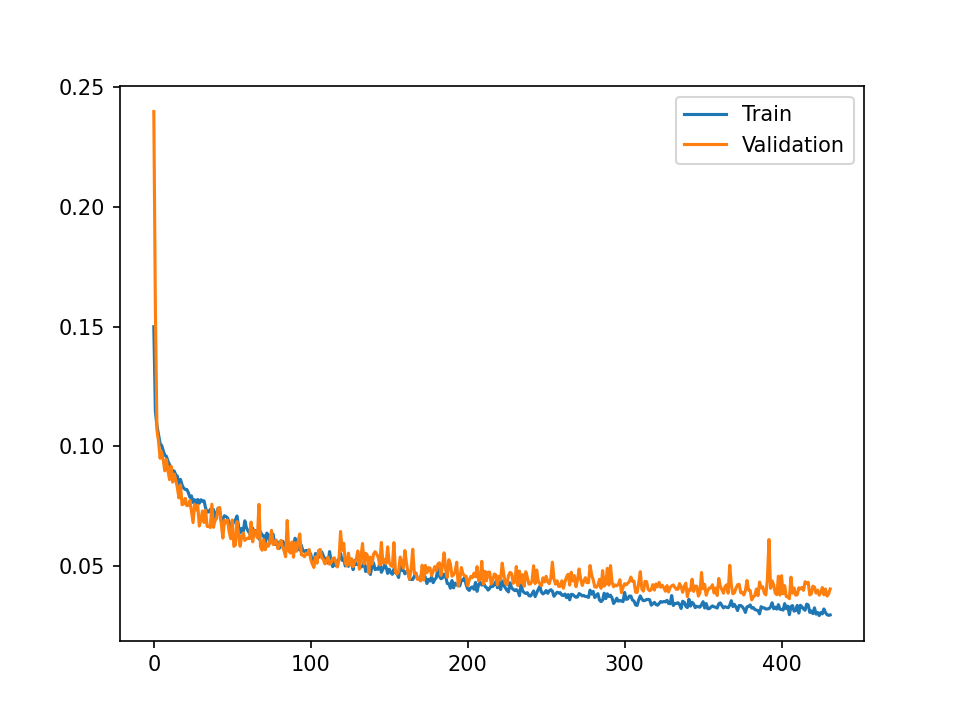

In [151]:
%matplotlib auto
plt.plot(range(len(multi_fcs_train[0])), multi_fcs_train[0], label="Train")
plt.legend()
plt.show()
    
plt.plot(range(len(multi_fcs_val[0])), multi_fcs_val[0], label="Validation")
plt.legend()
plt.show()


In [ ]:
from IPython.display import clear_output
import time
def updatePlot(losses, val_losses, ax, label, epoch):
    # Clear the previous plot
    #clear_output(wait=True)
    ax.clear()
    
    print(losses[-1])

    # Add the new data point to the existing plot

    ax.plot(range(epoch+1), losses, label="Training")
    ax.plot(range(epoch+1), val_losses, label="Validation")

    ax.legend()
    
    ax.figure.canvas.draw()


    # Display the updated plot
   

<IPython.core.display.Javascript object>


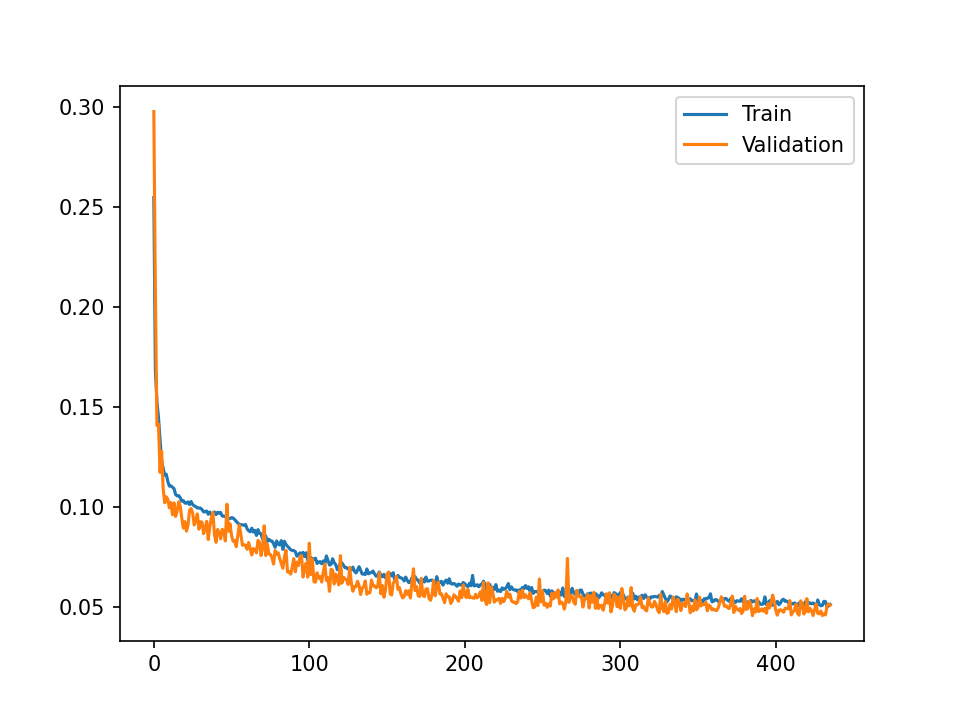

# Dropout in GRU layer

The Multi GRU Hidden no longer overfits, but has worse accuracy. The Multi GRU Output still overfits.

In [8]:
# Remove one FC LAyer
class MultiGRU(nn.Module):
    def __init__(self, hidden_size=256, single_fc=True, out="f_hidden"):
        super(MultiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.out = out
        
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.gru = nn.GRU(15, hidden_size, batch_first=True, dropout=0.5)
        
        input_tensor = torch.zeros(32, 512, 15)
        output, hidden = self.gru(input_tensor)
        

        fc_in = hidden_size
        if out == 'output':
            fc_in = output.shape[1] * output.shape[2]
        elif out == 'f-output':
            fc_in = output.shape[2]
        elif out == 'hidden':
            out = hidden_size * output.shape[2]
        elif out == 'f-hiden':
            fc_in = output.shape[2]
        elif out == 'h+o':
            fc_in = output.shape[1]
        
        if single_fc:
            self.fc = nn.Linear(fc_in, 6)
        else:
            self.fc = nn.Sequential(
                #nn.Dropout(0.5),
                nn.Linear(fc_in, 128),
                #nn.Dropout(0.25),
                nn.ReLU(),
                nn.Linear(128 , 64),
                #nn.Dropout(0.25),
                nn.ReLU(),
                nn.Linear(64, 6),
                #nn.Dropout(0.25)
            )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        #h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        o, h = self.gru(x)
        
        if self.out == "f_hidden":
            x = h[-1].reshape(batch_size, -1)
        elif self.out == "hidden":
            x = h.reshape(batch_size, -1)
        elif self.out == "f_output":
            x = o[:, -1, :].reshape(batch_size, -1)
        elif self.out == "output":
            x = o.reshape(batch_size, -1)
        elif self.out == "h+o":
            x = torch.concat([h[-1], o[:, -1, :]], dim=1).view(o.size(0), -1)
            
        x = self.fc(x)
        return x

In [9]:
names = ['Multi GRU Output',
 'Multi GRU Hidden']

In [10]:
multi_fcs = [
    MultiGRU(out="output", single_fc=False),
    MultiGRU(out="hidden", single_fc=False),
]

C:\Users\rjsou\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [11]:
single_fcs_train, single_fcs_val = [], []
multi_fcs_train, multi_fcs_val = [], []

for i, model in enumerate(multi_fcs):
    print(f"Training multi fc model {i+1}/{len(names)} using {names[i]}")
    train_loss, val_loss = train(train_loader, model, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)
    multi_fcs_train.append(train_loss)
    multi_fcs_val.append(val_loss)
    print("\n")

Training multi fc model 1/2 using Multi GRU Output
Using: cuda:0


100%|███████████████████████████████████| 56/56 [00:02<00:00, 22.54batch/s, counter=2, lastLoss=0.0621, valLoss=0.0629]


100%|███████████████████████████████████| 56/56 [00:02<00:00, 22.68batch/s, counter=2, lastLoss=0.0486, valLoss=0.0511]


100%|███████████████████████████████████| 56/56 [00:02<00:00, 22.64batch/s, counter=1, lastLoss=0.0391, valLoss=0.0491]


100%|████████████████████████████████████| 56/56 [00:02<00:00, 22.45batch/s, counter=0, lastLoss=0.035, valLoss=0.0403]


100%|███████████████████████████████████| 56/56 [00:02<00:00, 21.99batch/s, counter=0, lastLoss=0.0317, valLoss=0.0369]


100%|██████████████████████████████████| 56/56 [00:02<00:00, 21.43batch/s, counter=14, lastLoss=0.0278, valLoss=0.0356]


100%|██████████████████████████████████| 56/56 [00:02<00:00, 22.95batch/s, counter=49, lastLoss=0.0258, valLoss=0.0367]


Early stopping after 463 epochs
Average train loss: 0.013390987581096678
Average validation loss: 0.015686548126840758


Training multi fc model 2/2 using Multi GRU Hidden
Using: cuda:0


100%|██████████████████████████████████| 56/56 [00:01<00:00, 46.34batch/s, counter=11, lastLoss=0.0847, valLoss=0.0833]


100%|██████████████████████████████████| 56/56 [00:01<00:00, 42.54batch/s, counter=12, lastLoss=0.0696, valLoss=0.0754]


100%|███████████████████████████████████| 56/56 [00:01<00:00, 45.43batch/s, counter=5, lastLoss=0.0541, valLoss=0.0574]


100%|██████████████████████████████████| 56/56 [00:01<00:00, 46.20batch/s, counter=12, lastLoss=0.0477, valLoss=0.0498]


100%|██████████████████████████████████| 56/56 [00:01<00:00, 45.57batch/s, counter=15, lastLoss=0.0433, valLoss=0.0488]


100%|██████████████████████████████████| 56/56 [00:01<00:00, 45.73batch/s, counter=19, lastLoss=0.0414, valLoss=0.0438]


100%|███████████████████████████████████| 56/56 [00:01<00:00, 46.15batch/s, counter=19, lastLoss=0.0349, valLoss=0.046]


100%|███████████████████████████████████| 56/56 [00:01<00:00, 45.27batch/s, counter=0, lastLoss=0.0329, valLoss=0.0369]


100%|██████████████████████████████████| 56/56 [00:01<00:00, 28.30batch/s, counter=20, lastLoss=0.0291, valLoss=0.0395]


100%|██████████████████████████████████| 56/56 [00:01<00:00, 28.38batch/s, counter=40, lastLoss=0.0273, valLoss=0.0468]


100%|██████████████████████████████████| 56/56 [00:02<00:00, 25.59batch/s, counter=49, lastLoss=0.0259, valLoss=0.0365]


Early stopping after 689 epochs
Average train loss: 0.022769167408724096
Average validation loss: 0.02545335322367027




Training multi fc model 1/2 using Multi GRU Output


100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 52.18 batch/s]


(93.61344337463379, array([96.70748, 86.23732, 99.82669, 99.84199, 84.74609, 94.32108],
      dtype=float32), 0.03525916337966919)


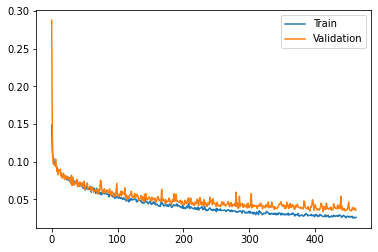

Training multi fc model 2/2 using Multi GRU Hidden


100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 58.94 batch/s]


(93.82097101211548, array([96.282524, 86.12079 , 99.79751 , 99.810974, 85.36675 , 95.54728 ],
      dtype=float32), 0.03918418101966381)


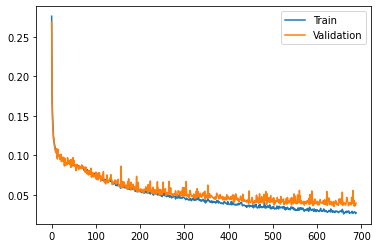

In [12]:
for i, model in enumerate(multi_fcs):
    print(f"Training multi fc model {i+1}/{len(names)} using {names[i]}")
    print(test(test_loader, model, scaler))
    
    plt.plot(range(len(multi_fcs_train[i])), multi_fcs_train[i], label="Train")
    plt.plot(range(len(multi_fcs_val[i])), multi_fcs_val[i], label="Validation")
    
    plt.legend()
    plt.show()

# Dropout before FC

In [45]:
# Remove one FC LAyer
class MultiGRU(nn.Module):
    def __init__(self, hidden_size=256, single_fc=True, out="f_hidden"):
        super(MultiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.out = out
        
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.gru = nn.GRU(15, hidden_size, batch_first=True, dropout=0.25)
        
        input_tensor = torch.zeros(32, 512, 15)
        output, hidden = self.gru(input_tensor)
        

        fc_in = hidden_size
        if out == 'output':
            fc_in = output.shape[1] * output.shape[2]
        elif out == 'f-output':
            fc_in = output.shape[2]
        elif out == 'hidden':
            out = hidden_size * output.shape[2]
        elif out == 'f-hiden':
            fc_in = output.shape[2]
        elif out == 'h+o':
            fc_in = output.shape[1]
        
        if single_fc:
            self.fc = nn.Linear(fc_in, 6)
        else:
            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(fc_in, 128),
                nn.ReLU(),
                nn.Linear(128 , 64),
                nn.ReLU(),
                nn.Linear(64, 6),
            )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        #h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        o, h = self.gru(x)
        
        if self.out == "f_hidden":
            x = h[-1].reshape(batch_size, -1)
        elif self.out == "hidden":
            x = h.reshape(batch_size, -1)
        elif self.out == "f_output":
            x = o[:, -1, :].reshape(batch_size, -1)
        elif self.out == "output":
            x = o.reshape(batch_size, -1)
        elif self.out == "h+o":
            x = torch.concat([h[-1], o[:, -1, :]], dim=1).view(o.size(0), -1)
            
        x = self.fc(x)
        return x

In [46]:
names = ['Multi GRU Output',
 'Multi GRU Hidden']

In [47]:
multi_fcs = [
    MultiGRU(out="output", single_fc=False),
    MultiGRU(out="hidden", single_fc=False),
]

C:\Users\rjsou\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [48]:
single_fcs_train, single_fcs_val = [], []
multi_fcs_train, multi_fcs_val = [], []

for i, model in enumerate(multi_fcs):
    print(f"Training multi fc model {i+1}/{len(names)} using {names[i]}")
    train_loss, val_loss = train(train_loader, model, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)
    multi_fcs_train.append(train_loss)
    multi_fcs_val.append(val_loss)
    print("\n")

Training multi fc model 1/2 using Multi GRU Output
Using: cuda:0


100%|████████████████████████████████████| 56/56 [00:03<00:00, 15.40batch/s, counter=2, lastLoss=0.0627, valLoss=0.064]


100%|████████████████████████████████████| 56/56 [00:03<00:00, 15.04batch/s, counter=15, lastLoss=0.0481, valLoss=0.05]


100%|███████████████████████████████████| 56/56 [00:04<00:00, 13.20batch/s, counter=5, lastLoss=0.0401, valLoss=0.0492]


100%|████████████████████████████████████| 56/56 [00:03<00:00, 14.89batch/s, counter=6, lastLoss=0.036, valLoss=0.0432]


100%|██████████████████████████████████| 56/56 [00:04<00:00, 12.19batch/s, counter=18, lastLoss=0.0328, valLoss=0.0389]


100%|███████████████████████████████████| 56/56 [00:07<00:00,  7.87batch/s, counter=4, lastLoss=0.0295, valLoss=0.0362]


100%|██████████████████████████████████| 56/56 [00:07<00:00,  7.97batch/s, counter=49, lastLoss=0.0274, valLoss=0.0376]


Early stopping after 473 epochs
Average train loss: 0.013784875667277013
Average validation loss: 0.0158940311645882


Training multi fc model 2/2 using Multi GRU Hidden
Using: cuda:0


100%|█████████████████████████████████████| 56/56 [00:06<00:00,  8.10batch/s, counter=2, lastLoss=0.09, valLoss=0.0829]


100%|███████████████████████████████████| 56/56 [00:05<00:00, 10.39batch/s, counter=9, lastLoss=0.0737, valLoss=0.0663]


100%|███████████████████████████████████| 56/56 [00:05<00:00, 10.59batch/s, counter=8, lastLoss=0.0645, valLoss=0.0626]


100%|██████████████████████████████████| 56/56 [00:04<00:00, 12.37batch/s, counter=13, lastLoss=0.0581, valLoss=0.0634]


100%|███████████████████████████████████| 56/56 [00:04<00:00, 11.57batch/s, counter=7, lastLoss=0.0565, valLoss=0.0562]


100%|███████████████████████████████████| 56/56 [00:03<00:00, 15.67batch/s, counter=37, lastLoss=0.053, valLoss=0.0553]


100%|████████████████████████████████████| 56/56 [00:03<00:00, 14.94batch/s, counter=49, lastLoss=0.054, valLoss=0.053]


Early stopping after 420 epochs
Average train loss: 0.020003565422081874
Average validation loss: 0.019422978579832446




Training multi fc model 1/2 using Multi GRU Output


100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 50.08 batch/s]


(93.72430419921875, array([96.56026 , 86.31373 , 99.821   , 99.803314, 84.71706 , 95.13047 ],
      dtype=float32), 0.03802359389762084)


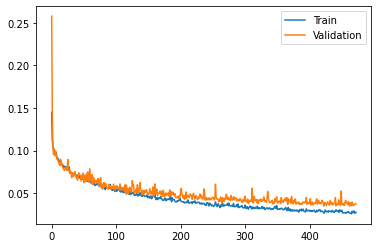

Training multi fc model 2/2 using Multi GRU Hidden


100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 56.29 batch/s]


(92.35162687301636, array([94.340935, 81.74727 , 99.7301  , 99.76126 , 84.366035, 94.16416 ],
      dtype=float32), 0.055304479350646335)


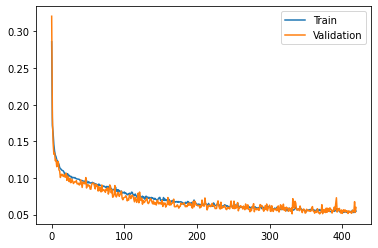

In [49]:
for i, model in enumerate(multi_fcs):
    print(f"Training multi fc model {i+1}/{len(names)} using {names[i]}")
    print(test(test_loader, model, scaler))
    
    plt.plot(range(len(multi_fcs_train[i])), multi_fcs_train[i], label="Train")
    plt.plot(range(len(multi_fcs_val[i])), multi_fcs_val[i], label="Validation")
    
    plt.legend()
    plt.show()